# set up and get data

In [1]:

!pip install --upgrade pip setuptools wheel
!pip install tensorflow
!pip install opencv-python matplotlib albumentations labelme


  Using cached pip-24.0-py3-none-any.whl.metadata (3.6 kB)
  Using cached setuptools-70.0.0-py3-none-any.whl.metadata (5.9 kB)
  Using cached wheel-0.43.0-py3-none-any.whl.metadata (2.2 kB)
Using cached pip-24.0-py3-none-any.whl (2.1 MB)
Using cached setuptools-70.0.0-py3-none-any.whl (863 kB)
Using cached wheel-0.43.0-py3-none-any.whl (65 kB)


ERROR: To modify pip, please run the following command:
C:\Users\user\anaconda3\python.exe -m pip install --upgrade pip setuptools wheel


# 2.Collect images using opencv

In [2]:
import cv2
import os
import time
import uuid


In [3]:
IMAGES_PATH =os.path.join('data','images')
number_images =30

In [4]:
cap =cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret,frame =cap.read()
    imgname =os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname,frame)
    cv2.imshow('frame',frame)
    time.sleep(0.5)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
         break
cap.release()
cv2.destroyAllWindows()

 # .3 Annotate the image   with labelme

In [5]:

!pip install labelme


In [6]:
!labelme


2024-06-09 08:12:21,931 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\user\.labelmerc


# 2.Review Dataset and Build Image Loading Function


In [7]:
import  tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

# 2.2Limit GPU memory growth


In [8]:
gpus =tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [9]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# 2.3 load the images into tf data pipeline

In [10]:
images =tf.data.Dataset.list_files('data\\images\\*.jpg',shuffle=False)

In [11]:
def load_image(x):
  byte_img =tf.io.read_file(x)
  img=tf.io.decode_jpeg(byte_img)
  return img;

In [12]:
images =images.map(load_image)

In [13]:
images.as_numpy_iterator().next()

array([[[146, 128, 144],
        [145, 127, 143],
        [149, 126, 142],
        ...,
        [111,  99, 135],
        [113, 102, 142],
        [113, 102, 142]],

       [[148, 130, 146],
        [147, 129, 143],
        [150, 129, 144],
        ...,
        [110,  99, 133],
        [110, 100, 137],
        [111, 101, 138]],

       [[148, 132, 145],
        [148, 132, 145],
        [148, 132, 145],
        ...,
        [108,  99, 128],
        [109,  99, 133],
        [110, 100, 134]],

       ...,

       [[134, 119, 140],
        [132, 119, 137],
        [132, 119, 136],
        ...,
        [141, 126, 131],
        [141, 126, 131],
        [138, 123, 128]],

       [[131, 117, 140],
        [131, 118, 138],
        [131, 118, 135],
        ...,
        [144, 128, 131],
        [138, 122, 125],
        [133, 117, 120]],

       [[132, 118, 141],
        [132, 119, 139],
        [130, 119, 136],
        ...,
        [145, 126, 130],
        [138, 119, 123],
        [135, 116, 120]]

In [14]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

# 2.3 view raw images with matplotlib

In [15]:
image_generator =images.batch(4).as_numpy_iterator()

In [16]:
plot_images =image_generator.next()

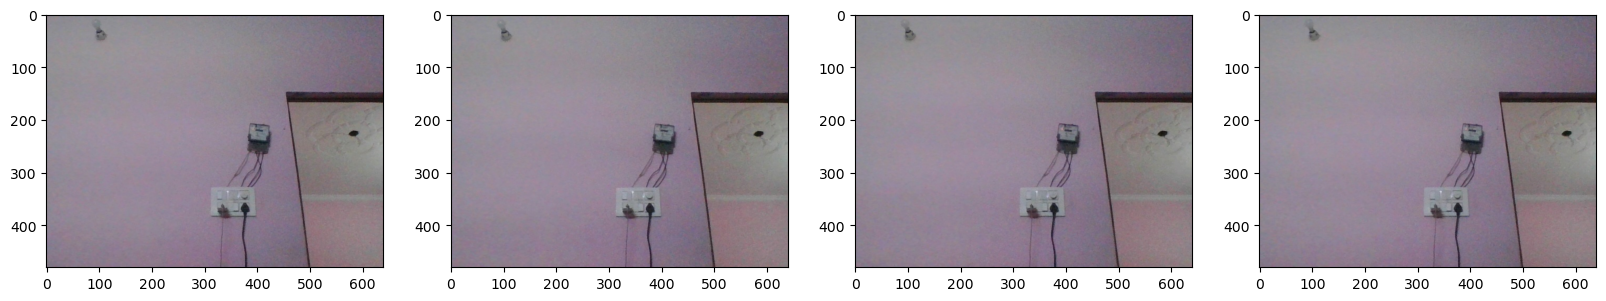

In [17]:
fig, ax=plt.subplots(ncols=4, figsize=(20,20))
for idx,image in enumerate(plot_images):
     ax[idx].imshow(image)
plt.show()    

# 3.partition Unaugmented data 

### manually split data into test and train and val

In [18]:
90* .7 # 63 to train

62.99999999999999

In [19]:
90* .15 # 14 and 13 to test

13.5

In [20]:
 for folder in ['train','test','val']:
     for file in os.listdir(os.path.join('data',folder,'images')):
         filename =file.split('.')[0]+ '.json'
         existing_filepath =os.path.join('data','labels',filename)
         if os.path.exists(existing_filepath):
             new_filepath =os.path.join('data',folder,'labels',filename)
             os.replace(existing_filepath,new_filepath)
             

# 4. Apply Image Augmentation on Images and labels using Albumentation

In [21]:
import albumentations as alb

In [22]:
augmentor = alb.Compose([
    alb.RandomCrop(width=450, height=450),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5)],
   bbox_params=alb.BboxParams(format='albumentations',label_fields=['class_labels']))

# load a test image and annotations with open cv and json

In [23]:
img = cv2.imread(os.path.join('data','train','images','03655ead-243b-11ef-8ee0-a8b13bae3649.jpg'))

In [24]:
with open(os.path.join('data','train','labels','03655ead-243b-11ef-8ee0-a8b13bae3649.json'),'r') as f:
    label = json.load(f)

In [25]:
label['shapes'][0]['points']

[[259.20000000000005, 202.39999999999998], [513.6, 424.8]]

# 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [26]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]


In [27]:
coords

[259.20000000000005, 202.39999999999998, 513.6, 424.8]

In [28]:

coords = list(np.divide(coords, [640,480,640,480]))

In [29]:

coords

[0.4050000000000001, 0.42166666666666663, 0.8025, 0.885]

# 4.4 Apply Augmentations and View Results

In [30]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [31]:

augmented['bboxes'][0][2:]

(0.7217777777777776, 0.5924444444444444)

In [32]:
augmented['bboxes']

[(0.15644444444444439,
  0.09822222222222221,
  0.7217777777777776,
  0.5924444444444444)]

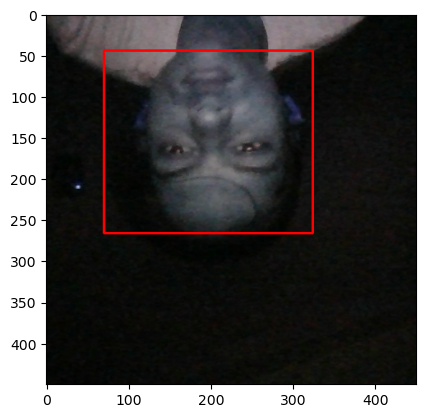

In [33]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline
# 5.1 Run Augmentation Pipeline

In [34]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

image must be numpy array type
image must be numpy array type
image must be numpy array type
image must be numpy array type


# 5.2 Load Augmented Images to Tensorflow Dataset

In [35]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [36]:

test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [37]:

val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [38]:
train_images.as_numpy_iterator().next()

array([[[0.05845588, 0.22316177, 0.14473039],
        [0.05373774, 0.21844363, 0.14001225],
        [0.05147059, 0.21176471, 0.13480392],
        ...,
        [0.06617647, 0.21911764, 0.1367647 ],
        [0.05606618, 0.2276348 , 0.13792892],
        [0.04797794, 0.21960784, 0.13033088]],

       [[0.05863971, 0.21158089, 0.13707107],
        [0.07990196, 0.23284313, 0.15833333],
        [0.06807598, 0.22101715, 0.14650735],
        ...,
        [0.06715687, 0.22009803, 0.1377451 ],
        [0.05882353, 0.21519607, 0.12254902],
        [0.05208333, 0.21550246, 0.12659314]],

       [[0.05949755, 0.21243873, 0.13792892],
        [0.0759804 , 0.22892156, 0.15441176],
        [0.0788603 , 0.23180147, 0.15729167],
        ...,
        [0.07401961, 0.22696078, 0.15245098],
        [0.06666667, 0.21617647, 0.13382353],
        [0.06023284, 0.20680147, 0.13180147]],

       ...,

       [[0.44852942, 0.5897059 , 0.5377451 ],
        [0.4783701 , 0.6166054 , 0.58866423],
        [0.47438726, 0

# 6. Prepare Labels
6.1 Build Label Loading Function


In [39]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

# 6.2 Load Labels to Tensorflow Dataset

In [40]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [41]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [42]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [43]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.    , 0.4094, 0.4663, 0.968 ], dtype=float16))


 # 7. Combine Label and Image Samples
# 7.1 Check Partition Lengths

In [44]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 900, 900, 780, 780)

# 7.2 Create Final Datasets (Images/Labels)

In [45]:

train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [46]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)


In [47]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)


In [48]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.694 , 0.388 , 0.9976, 0.7417],
        [0.1387, 0.2129, 0.5103, 0.631 ],
        [0.3586, 0.3533, 0.942 , 0.963 ],
        [0.    , 0.4497, 0.4275, 0.88  ],
        [0.2637, 0.5063, 0.788 , 0.9136],
        [0.2115, 0.2703, 0.521 , 0.647 ],
        [0.5596, 0.1387, 0.979 , 0.546 ],
        [0.2048, 0.1267, 0.646 , 0.539 ]], dtype=float16))

# 7.3 View Images and Annotations

In [49]:
data_samples = train.as_numpy_iterator()

In [50]:
res = data_samples.next()

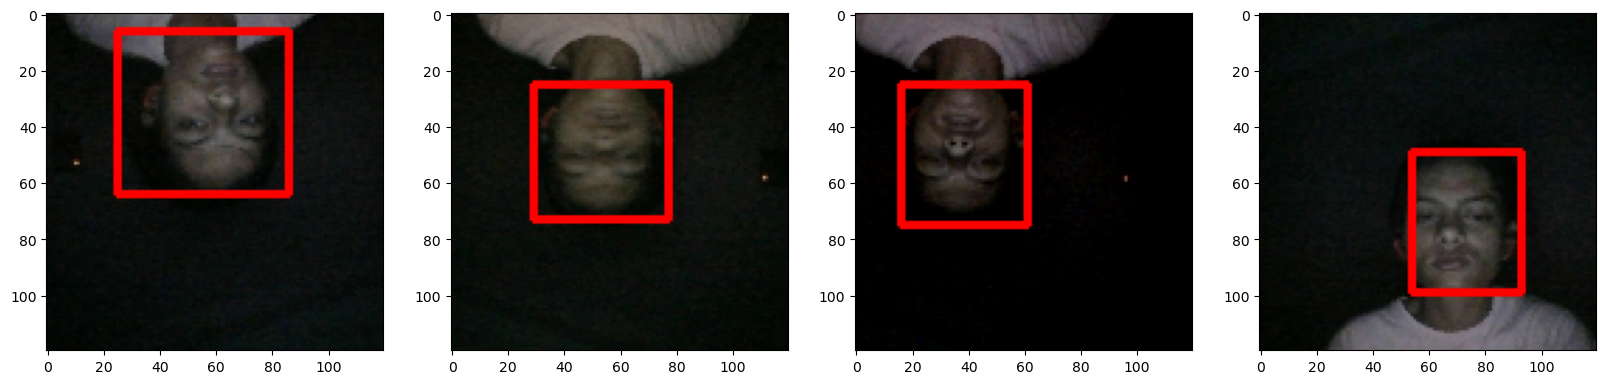

In [52]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx].copy()
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)
  

# 8. Build Deep Learning using the Functional API
 ## 8.1 Import Layers and Base Network

In [53]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16


# 8.2 Download VGG16


In [54]:

vgg = VGG16(include_top=False)

In [55]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape               ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)      │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)     │           1,792 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)     │          36,928 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)     │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)    │          73,856 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)    │         147,584 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)    │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)    │         295,168 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)    │         590,080 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)    │         590,080 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)    │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)    │       1,180,160 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)    │       2,359,808 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)    │       2,359,808 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)    │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)    │       2,359,808 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)    │       2,359,808 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)    │       2,359,808 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)    │               0 │
└──────────────────────────────────────┴────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

# 8.3 Build instance of Network

In [57]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

# 8.4 Test out Neural Network

In [59]:

facetracker = build_model()

In [60]:
facetracker.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)            ┃ Output Shape        ┃      Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3           │ (None, 120, 120, 3) │            0 │ -                    │
│ (InputLayer)            │                     │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ vgg16 (Functional)      │ (None, 3, 3, 512)   │   14,714,688 │ input_layer_3[0][0]  │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ global_max_pooling2d_2  │ (None, 512)         │            0 │ vgg16[0][0]          │
│ (GlobalMaxPooling2D)    │                     │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ global_max_pooling2d_3  │ (None, 512)         │            0 │ vgg16[0][0]          │
│ (GlobalMaxPooling2D)    │                     │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ dense_4 (Dense)         │ (None, 2048)        │    1,050,624 │ global_max_pooling2… │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ dense_6 (Dense)         │ (None, 2048)        │    1,050,624 │ global_max_pooling2… │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ dense_5 (Dense)         │ (None, 1)           │        2,049 │ dense_4[0][0]        │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ dense_7 (Dense)         │ (None, 4)           │        8,196 │ dense_6[0][0]        │
└─────────────────────────┴─────────────────────┴──────────────┴──────────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:

X, y = train.as_numpy_iterator().next()

In [62]:
X.shape


(8, 120, 120, 3)

In [63]:
classes, coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [64]:

classes, coords

(array([[0.40136135],
        [0.36817217],
        [0.41030854],
        [0.40375045],
        [0.42211953],
        [0.3875162 ],
        [0.42560315],
        [0.3886549 ]], dtype=float32),
 array([[0.46789497, 0.44255197, 0.5267136 , 0.5786222 ],
        [0.52201176, 0.42954263, 0.4853044 , 0.561097  ],
        [0.4882815 , 0.39874586, 0.54267883, 0.61451304],
        [0.46421447, 0.44293198, 0.50767297, 0.58237934],
        [0.4970508 , 0.48547384, 0.432959  , 0.64434564],
        [0.3897819 , 0.43872115, 0.5908973 , 0.5997207 ],
        [0.47793597, 0.4640738 , 0.4884461 , 0.601907  ],
        [0.4516446 , 0.49268433, 0.5045631 , 0.59353364]], dtype=float32))

# 9. Define Losses and Optimizers

# 9.1 Define Optimizer and LR

In [65]:

batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [66]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

C:\Users\user\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


# 9.2 Create Localization Loss and Classification Loss

In [67]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [68]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

# 9.3 Test out Loss Metrics

In [70]:

localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=2.454062>

In [71]:

classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.91495967>

In [72]:

regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=2.454062>

# 10. Train Neural Network

#  10.1 Create Custom Model Class

In [119]:

class FaceTracker(Model):
   def __init__(self, eyetracker, **kwargs):
     super().__init__(**kwargs)
     self.model = eyetracker

   def compile(self, opt, classloss, localizationloss, **kwargs):
     super().compile(**kwargs)
     self.closs = classloss
     self.lloss = localizationloss
     self.opt = opt

   @tf.function  # Decorate train_step with @tf.function
   def train_step(self, batch, **kwargs):
     X, y = batch

     with tf.GradientTape() as tape:
       try:
         classes, coords = self.model(X, training=True)

         
         y_0 = tf.reshape(y[0], [-1, 1])  

         

         batch_classloss = self.closs(y_0, classes)
         batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32),
         coords)
         total_loss = batch_localizationloss + 0.5 * batch_classloss

       except tf.errors.InvalidArgumentError as e:

         if 'Input tensors must be of size at least 1' in str(e):
           return {"total_loss": tf.constant(0.0)}  # Dummy loss (optional)
         else:
           raise e  

       grad = tape.gradient(total_loss, self.model.trainable_variables)
       self.opt.apply_gradients(zip(grad, self.model.trainable_variables))

     return {"total_loss": total_loss, "class_loss": batch_classloss,
         "regress_loss": batch_localizationloss}

   def test_step(self, batch, **kwargs):
     X, y = batch
     classes, coords = self.model(X, training=False)

  
     y_0 = tf.reshape(y[0], [-1, 1]) 


     batch_classloss = self.closs(y_0, classes)
     batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
     total_loss = batch_localizationloss + 0.5 * batch_classloss
     return {"total_loss": total_loss, "class_loss": batch_classloss,
        "regress_loss": batch_localizationloss}

   def call(self, X, **kwargs):
     return self.model(X, **kwargs)



In [120]:

model = FaceTracker(facetracker)

In [121]:
model.compile(opt, classloss, regressloss)

# 10.2 Train

In [122]:

logdir='logs'

In [123]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [125]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 810s 2s/step - class_loss: 0.0055 - regress_loss: 0.0899 - total_loss: 0.0926 - val_class_loss: 0.0014 - val_regress_loss: 0.1099 - val_total_loss: 0.1106
Epoch 2/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 756s 2s/step - class_loss: 2.4665e-04 - regress_loss: 0.0406 - total_loss: 0.0407 - val_class_loss: 9.6470e-05 - val_regress_loss: 0.0150 - val_total_loss: 0.0151
Epoch 3/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 779s 2s/step - class_loss: 8.9811e-05 - regress_loss: 0.0296 - total_loss: 0.0296 - val_class_loss: 7.3200 - val_regress_loss: 1.1354 - val_total_loss: 4.7954
Epoch 4/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 792s 2s/step - class_loss: 5.3115e-05 - regress_loss: 0.0249 - total_loss: 0.0249 - val_class_loss: 4.2499e-06 - val_regress_loss: 0.0774 - val_total_loss: 0.0774
Epoch 5/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 792s 2s/step - class_loss: 2.6136e-05 - regress_loss: 0.0209 - total_loss: 0.0209 - val_class_loss: 7.3461e-07 - val_regress_loss: 0.0643 - val_total_loss: 0.06

# 10.3 Plot Performance

In [126]:

hist.history

{'class_loss': [6.720839883200824e-05,
  0.00011999849084531888,
  4.780010931426659e-05,
  1.5640455330867553e-06,
  2.545489451222238e-06,
  7.924321835162118e-05,
  3.183591616107151e-05,
  3.1841613235883415e-05,
  7.69999871863547e-07,
  1.245598809873627e-06],
 'regress_loss': [0.04105209559202194,
  0.011465314775705338,
  0.008848312310874462,
  0.008049547672271729,
  0.01287843007594347,
  0.04444999620318413,
  0.027213631197810173,
  0.012564326636493206,
  0.004339221864938736,
  0.005636001005768776],
 'total_loss': [0.04108570143580437,
  0.011525314301252365,
  0.008872211910784245,
  0.008050329983234406,
  0.01287970319390297,
  0.04448961839079857,
  0.0272295493632555,
  0.012580247595906258,
  0.0043396069668233395,
  0.005636623594909906],
 'val_class_loss': [0.001423449139110744,
  9.64698992902413e-05,
  7.319972038269043,
  4.249906851327978e-06,
  7.346093866544834e-07,
  0.0009118157904595137,
  3.2911386489868164,
  1.926025652210228e-05,
  1.410556160408305

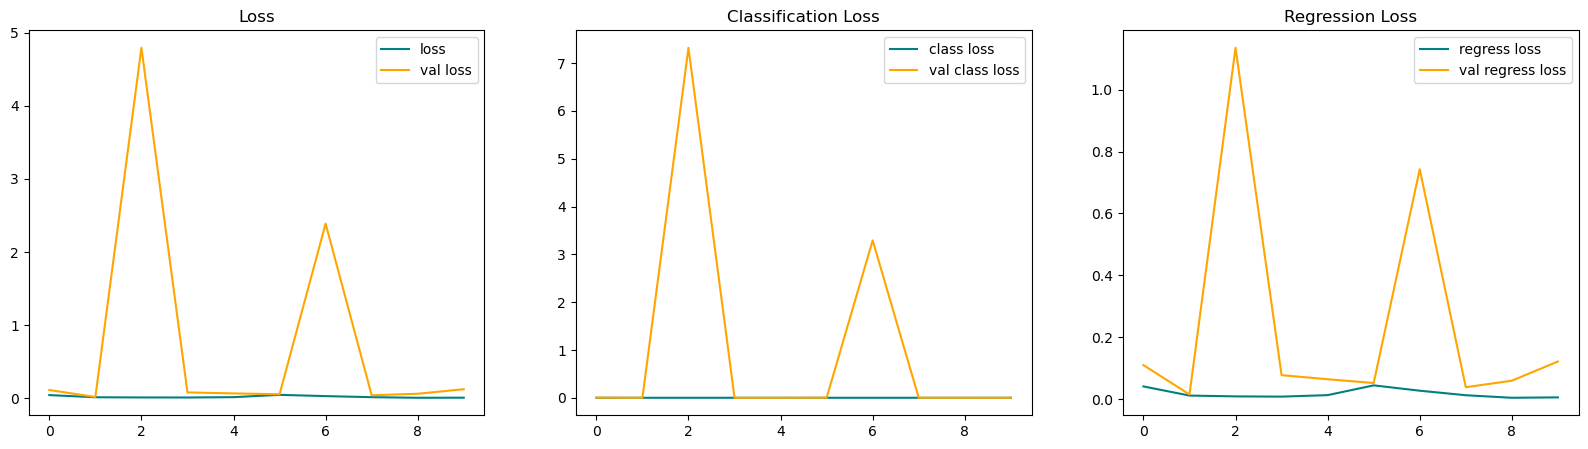

In [127]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

#  11.1 Make Predictions on Test Set

In [128]:
test_data = test.as_numpy_iterator()

In [129]:

test_sample = test_data.next()

In [130]:
yhat = facetracker.predict(test_sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


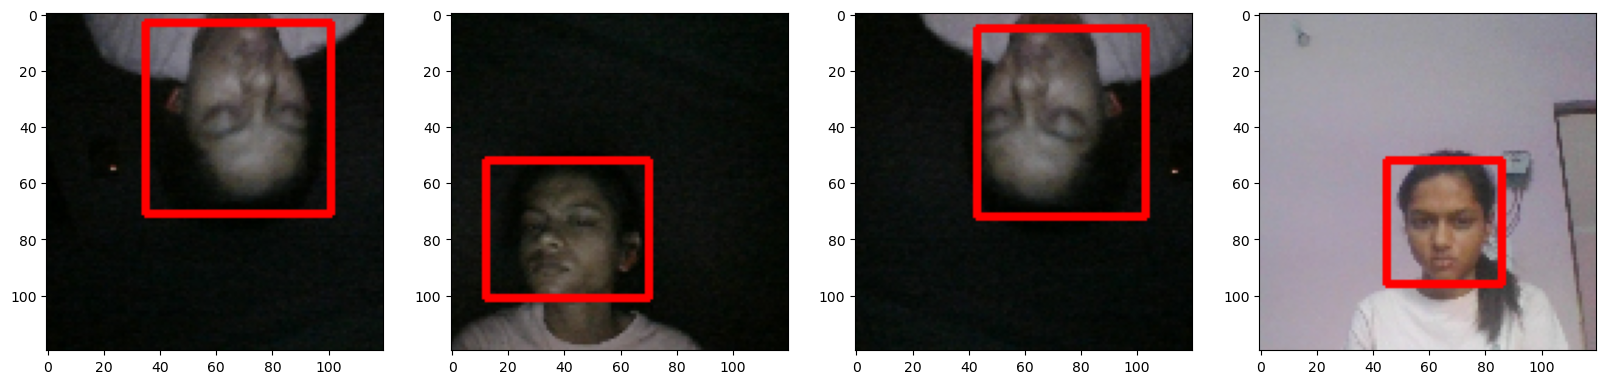

In [134]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image =np.copy(test_sample[0][idx])
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

# 11.2 Save the Model

In [144]:
from tensorflow.keras.models import load_model

In [145]:
facetracker.save('facetracker.keras')

In [146]:
facetracker = load_model('facetracker.keras')

# 11.3 Real Time Detection

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
                # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 